Importing Libraries


In [37]:
import os
import numpy as np
import pandas as pd
from skimage import io,color
from skimage import filters
from skimage import exposure
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,BisectingKMeans
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,DBSCAN
from sklearn.metrics import silhouette_score,fowlkes_mallows_score
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [38]:
root_dir = "C:/Users/rysad/OneDrive/Desktop/Data Science/DM-1/datasets/ResizedImages"


1. Feature extraction

In [39]:
def edge_histogram(image):
    im=angle(filters.sobel_h(image),filters.sobel_v(image))
    hist,_=exposure.histogram(im, nbins=36)
    return hist
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)
labels=[]
inputs=[]
for index, dog in enumerate(tqdm(os.listdir(root_dir))):
    path = os.path.join(root_dir, dog)
    if os.path.isdir(path): 
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isfile(file_path):
                img = io.imread(file_path)
                gray_img = color.rgb2gray(img)
                hists = edge_histogram(gray_img)
                inputs.append(hists)
                labels.append(index)
labels = np.array(labels)
inputs = np.array(inputs)


100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


In [40]:
print(len(inputs))
print("First input:", inputs[0])

868
First input: [777 692 704 628 559 522 482 431 388 382 334 270 337 325 305 306 299 328
 331 290 321 345 326 313 344 358 359 365 406 429 509 575 689 703 834 818]


Normalizing Edge Histograms Dataset


In [41]:
inputs_normalized = inputs / np.sum(inputs, axis=1, keepdims=True)

In [42]:
print(len(inputs_normalized))
print("First input:", inputs_normalized[0])

input_sum = np.sum(inputs_normalized[0])
print("Sum of the input array:", input_sum)


868
First input: [0.04742432 0.04223633 0.04296875 0.03833008 0.03411865 0.03186035
 0.02941895 0.02630615 0.02368164 0.02331543 0.02038574 0.01647949
 0.02056885 0.01983643 0.01861572 0.01867676 0.01824951 0.02001953
 0.02020264 0.0177002  0.01959229 0.02105713 0.01989746 0.019104
 0.02099609 0.02185059 0.02191162 0.02227783 0.02478027 0.02618408
 0.03106689 0.03509521 0.04205322 0.04290771 0.05090332 0.04992676]
Sum of the input array: 1.0


2. Dimension Reduction Using PCA


In [43]:
pca_algorithm=PCA(n_components=2)
inputs_normalized=pca_algorithm.fit_transform(inputs_normalized)

In [44]:
print("Length of inputs_normalized after PCA dimensionality reduction:", len(inputs_normalized))
print("Shape of inputs_normalized after PCA dimensionality reduction:", inputs_normalized.shape)


Length of inputs_normalized after PCA dimensionality reduction: 868
Shape of inputs_normalized after PCA dimensionality reduction: (868, 2)


In [48]:
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
import pandas as pd
from sklearn.cluster import Birch

3. Clustering Algorithm (k-means, k-means++, Bisecting K-means, Spectral Clustering) and DBSCAN  and Agglomerative Clustering (Single Link, Complete Link, Group Average, and Ward's Method) and 4. Clustering Evaluations

eps= 0.04 and min_samples = 4 to get 4 clusters

a) Fowlkes-Mallows Index and b) Silhouette Coefficient

In [58]:
# List of clustering algorithms to evaluate
algos = [
 ('K-means (Random)', KMeans(n_clusters=4, random_state=42, init="random")),
 ('K-means (K-means++)', KMeans(n_clusters=4, random_state=42, init="k-means++")),
 ('Bisecting K-means', BisectingKMeans(n_clusters=4, random_state=42, init="random")),
 ('Spectral Clustering', SpectralClustering(n_clusters=4)),
 ('DBSCAN', DBSCAN(eps=0.04, min_samples=4)),
 ('Agg. Clustering (Single)', AgglomerativeClustering(n_clusters=4, linkage='single')),
 ('Agg. Clustering (Complete)', AgglomerativeClustering(n_clusters=4, linkage='complete')),
 ('Agg. Clustering (Average)', AgglomerativeClustering(n_clusters=4, linkage='average')),
 ('Agg. Clustering (Ward)', AgglomerativeClustering(n_clusters=4, linkage='ward'))
]
scores = pd.DataFrame(columns=['algorithm', 'fowlkes', 'silhouette'])
for name, algo in algos:
    algo.fit(inputs_normalized)
    fowlkes = fowlkes_mallows_score(labels, algo.labels_)
    silhouette = silhouette_score(inputs_normalized, algo.labels_)
    scores = pd.concat([scores, pd.DataFrame({'algorithm': name, 'fowlkes': [fowlkes],
                                              'silhouette': [silhouette]})], ignore_index=True)
# Print the evaluation scores
print("Evaluation Scores:")
scores


Evaluation Scores:


,algorithm,fowlkes,silhouette
0,K-means (Random),0.310482,0.397831
1,K-means (K-means++),0.310482,0.397831
2,Bisecting K-means,0.309696,0.345637
3,Spectral Clustering,0.355583,0.024984
4,DBSCAN,0.505586,0.778213
5,Agg. Clustering (Single),0.505584,0.706403
6,Agg. Clustering (Complete),0.370284,0.430164
7,Agg. Clustering (Average),0.492176,0.424123
8,Agg. Clustering (Ward),0.313856,0.341028


c) Best to worst methods sorted for Fowlkes-Mallows index

In [59]:
sorted_scores = scores.sort_values(by='fowlkes', ascending=False)
sorted_scores[['algorithm','fowlkes']]

,algorithm,fowlkes
4,DBSCAN,0.505586
5,Agg. Clustering (Single),0.505584
7,Agg. Clustering (Average),0.492176
6,Agg. Clustering (Complete),0.370284
3,Spectral Clustering,0.355583
8,Agg. Clustering (Ward),0.313856
0,K-means (Random),0.310482
1,K-means (K-means++),0.310482
2,Bisecting K-means,0.309696


d) Best to worst methods sorted for Silhouette Coefficient

In [60]:
sorted_scores = scores.sort_values(by='silhouette', ascending=False)
sorted_scores[['algorithm','silhouette']]

,algorithm,silhouette
4,DBSCAN,0.778213
5,Agg. Clustering (Single),0.706403
6,Agg. Clustering (Complete),0.430164
7,Agg. Clustering (Average),0.424123
0,K-means (Random),0.397831
1,K-means (K-means++),0.397831
2,Bisecting K-means,0.345637
8,Agg. Clustering (Ward),0.341028
3,Spectral Clustering,0.024984


PCA representation of all algorithms

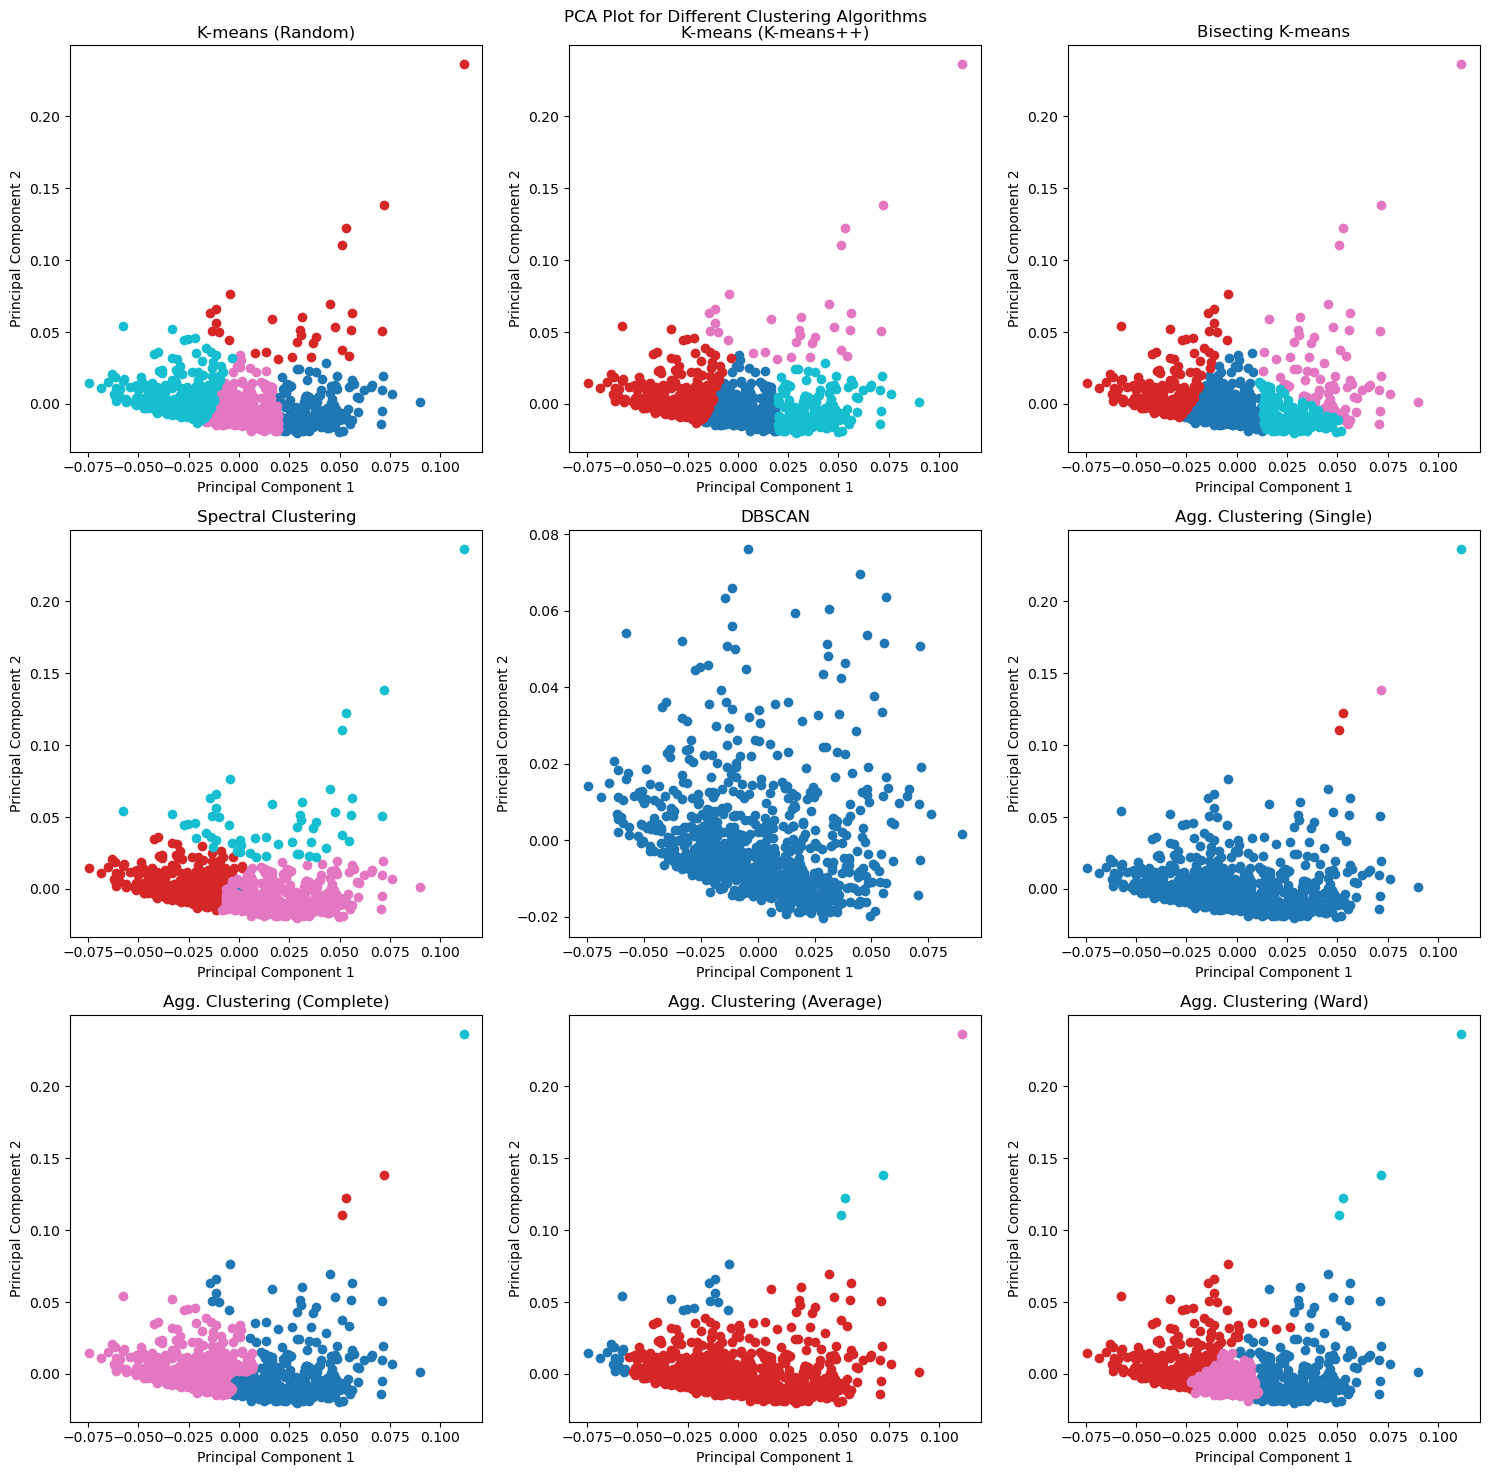

In [71]:
import matplotlib.pyplot as plt
labels_set = set(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(labels_set)))
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('PCA Plot for Different Clustering Algorithms')
for ax, (name, algo) in zip(axs.flat, algos):
 
    algo.fit(inputs_normalized)
    for i in labels_set:
        ax.scatter(inputs_normalized[algo.labels_ == i, 0], inputs_normalized[algo.labels_ == i, 1], color=colors[i], label=f'Class {i}')
    ax.set_title(name)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
plt.tight_layout()
plt.show()
